In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, History
from keras.regularizers import l2

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import keras_toolbox as tb
import random

Using Theano backend.


In [2]:
def get_index_of_maxes(tab, n):
    result = []
    for line in tab:
        foo = list(line)
        sub_result = []
        for i in range(n+1):
            the_max = max(foo)
            its_index = foo.index(the_max)
            sub_result.append(its_index)
            foo[its_index] = -100
        result.append(sub_result)
    return result

In [3]:
# encode moves quality
def create_2_labels(x, threshold):
    if x >= threshold:
        return "good"
    else:
        return "bad"
    
# cast types
def df_proper_types(dataf):
    cols = ['c'+str(i) for i in range(81)]+['nextMove', 'localMove']#['isWin', 'nextMove', 'localMove']
    for col in cols:
        dataf[col] = dataf[col].astype(int)
    return dataf

def shuffle(dataf):
    np.random.seed(int(time.time()))
    dataf = dataf.reindex(np.random.permutation(dataf.index))
    dataf = dataf.reset_index()
    dataf = dataf.drop(['index'],axis=1)
    return dataf
    
# one hot encoder
def one_hot(Y):
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    # convert integers to dummy variables (i.e. one hot encoded)
    return np_utils.to_categorical(encoded_Y), encoder.classes_

## For anyone reading this
The sort of ETL process I had was encoding the game : 9 tictactoe boards = 81 cells (+ state of those 9 boards),  representing a move by assocating the board before and after the move, another column to describe who won... 287 columns in the end.

In [4]:
df = pd.read_csv("t10_players_extract.csv")
#df = df_proper_types(df)
for col in df.columns:
    df[col] = df[col].astype(int)
print(df.shape)
df.head(3)

(62460, 287)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,macroToPlay,cp0,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,0,0


In [5]:
df = shuffle(df)

Separate train from test:

In [6]:
train_test_ratio = 0.75

n_samples = int(df.shape[0] * train_test_ratio)

df_train = df.copy()
df_train = df_train[:n_samples]

df_test = df.copy()
df_test = df_test[n_samples:]
df_test = df_test.reset_index()
df_test = df_test.drop('index',axis=1)
#df_test.head(2)

In [7]:
# subset of columns
def get_X_Y(df):
    X_columns = ['c'+str(i) for i in range(81)]+['m'+str(i) for i in range(9)] + ['cp'+str(i) for i in range(9)]
    y_column  = ['localMove']#['localMove']
    X = df[X_columns].values
    Y = one_hot(df[y_column])
    return X, Y[0], Y[1]

In [7]:
# using everything
def get_X_Y_2(df):
    X_columns = ['p1c_'+str(i) for i in range(81)]+['p1m_'+str(i) for i in range(9)] 
    X_columns+= ['p2c_'+str(i) for i in range(81)]+['p2m_'+str(i) for i in range(9)] +['cp'+str(i) for i in range(9)]
    y_column  = ['localMove']#['localMove']
    X = df[X_columns].values
    Y = one_hot(df[y_column])
    return X, Y[0], Y[1]

In [8]:
X_train, y_train, _ = get_X_Y_2(df_train)
X_test, y_test, classes_names   = get_X_Y_2(df_test)

/home/kevin/.virtualenvs/AiScraperEnv/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kevin/.virtualenvs/AiScraperEnv/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- 25% with: 500, relu, W b regularizers, loss= 'categorical_crossentropy', adam, monitor:categorical_accuracy

compter les doublons

In [9]:
X_shape = (81 + 9) * 2 + 9
y_shape = 9

layers_size = [400,150] #400 200 100 50 0.2517, 6 4 2 2 2
layers_activtions = ['relu','relu']

model = Sequential()
for i in range(len(layers_size)):
    size = layers_size[i]
    activation = layers_activtions[i]
    model.add(Dense(size, input_dim=X_shape, init='uniform', activation=activation # lecun_uniform
                    #, W_regularizer=l2(1e-4)
                    #, b_regularizer=l2(1e-4)
                   ))

model.add(Dense(y_shape, init='lecun_uniform', activation='softmax' # lecun_uniform
                #, W_regularizer=l2(1e-4)
               #, b_regularizer=l2(1e-4)
               ))

# Compile model
model.compile(loss= 'categorical_crossentropy' # binary_crossentropy
              , optimizer='adam' # sgd adam
              , metrics=['accuracy', 'categorical_accuracy']
              )

In [10]:
# testing accuracy on test set for each epoch
acc0 = -10
acc1 = 0
n_epo = 1
while acc1 - acc0 > 1e-6:
    model.fit(X_train, y_train
                             , nb_epoch=1 # maximum of epochs
                             , batch_size=2000 # training elements per batch
                             , verbose=0 # no outputs, it's buggy, 1 progression, 2 epoch metrics only
                             , shuffle = True # batch shuffling
                            )
    scores = model.evaluate(X_test, y_test, verbose=0)
    acc0 = acc1
    acc1 = scores[1]
    print("\r(n epochs:",n_epo,')',acc0,'=>',acc1, end="")
    n_epo += 1
print("\nended")

(n epochs: 5 ) 0.316170349014 => 0.307140569957
ended


In [47]:
# same but using builtin early stopping
early_stopping = EarlyStopping(monitor='categorical_accuracy' # loss
                               #, min_delta=1e-6
                             , patience=3)  # stop if no improvements after n epochs
history = History()
history_callback = model.fit(X_train, y_train
                             , nb_epoch=20 # maximum of epochs
                             , batch_size=2000 # training elements per batch
                             , verbose=0 # no outputs, it's buggy 1 progression, 2 epoch metrics only
                             , callbacks=[early_stopping, history]
                             , shuffle = True # batch shuffling
                             #, validation_data = (X_test, y_test)
                            )
print('n epoch:',len(history.epoch))

n epoch: 20


In [48]:
scores = model.evaluate(X_test, y_test) 
print("")
print("Test set:") 
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i], scores[i])

15456/15615 [============================>.] - ETA: 0s
Test set:
loss 2.78204746488
acc 0.363880883741
categorical_accuracy 0.363880883741


In [104]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_102 (Dense)                (None, 600)           54600       dense_input_39[0][0]             
____________________________________________________________________________________________________
dense_103 (Dense)                (None, 400)           240400      dense_102[0][0]                  
____________________________________________________________________________________________________
dense_104 (Dense)                (None, 9)             3609        dense_103[0][0]                  
Total params: 298609
____________________________________________________________________________________________________


In [30]:
# nb of coefficient in the NN
800 * 90 + 800 + 150 * 800 + 150 + 2 * 150 + 2

193252

In [18]:
y_pred = model.predict_classes(X_test, verbose=0)
foo = df_test['localMove'].values
bar = y_pred#.values
#bar
df_confusion = pd.crosstab(foo, bar)

aa = 0
for i in list(set(df_confusion.columns)):
    aa += df_confusion[i][i]
aa = aa / len(foo)
print('\nacc:',aa)
df_confusion


acc: 0.401857188601


col_0,0,1,2,3,4,5,6,7,8
row_0,,,,,,,,,
0,605,111,183,153,107,145,145,129,199
1,82,816,120,256,80,179,115,122,150
2,142,137,783,154,103,105,128,86,162
3,69,174,125,883,71,133,115,136,143
4,75,92,113,94,466,74,101,60,116
5,99,202,110,220,75,738,142,150,112
6,133,136,204,141,84,142,620,99,149
7,108,206,146,236,64,172,102,670,131
8,123,145,150,156,97,121,116,85,694


#### 40 % accuracy is better 1/9, but I am trying to reduce the branching factor not guessing the appropriate move. Adding the top *n* probabilities:

In [39]:
good_answer = get_index_of_maxes(y_test, 1)
y_pred = model.predict(X_test)
best_answers = get_index_of_maxes(y_pred, 9)

ok = []
ratio0 = 0
deltas = []
for foo in range(1, 9+1):
    oko = 0
    for i in range(len(best_answers)):
        if good_answer[i][0] in best_answers[i][:foo]:
            oko += 1
    #print('oks:', (ok/len(best_answers)))
    ratio = oko/len(best_answers)
    ok.append(ratio)
    deltas.append(ratio - ratio0)
    ratio0 = ratio
ok, deltas

([0.3910342619276337,
  0.6185078450208134,
  0.7776496958053154,
  0.8822926673070766,
  0.9439000960614794,
  0.9779699007364714,
  0.9949407620877362,
  0.9990393852065321,
  1.0],
 [0.3910342619276337,
  0.22747358309317967,
  0.15914185078450205,
  0.10464297150176116,
  0.06160742875440284,
  0.03406980467499199,
  0.0169708613512648,
  0.004098623118795941,
  0.0009606147934678733])

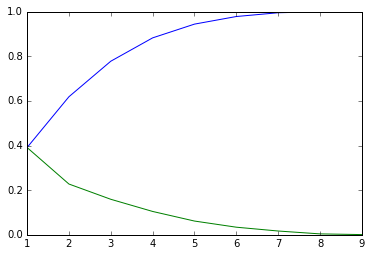

In [40]:
plt.plot(range(1,10), ok)
plt.plot(range(1,10), deltas)
plt.ylim(0,1)
plt.show()

##### When considering the 4 top moves out of 9, we have the good move with 85% confidence. Reducing by half the moves to test.

---